In [3]:
from PIL import Image
import numpy as np
import time 
import math
from matplotlib import pyplot as plt
import sys
import cv2
import imutils
import tensorflow as tf


from tensorflow.image import ResizeMethod 
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Standard PySceneDetect imports:
from scenedetect import VideoManager
from scenedetect import SceneManager

# For content-aware scene detection:|
from scenedetect.detectors import ContentDetector


## Entropy 

In [38]:
def color_entropy(signal):
    '''
    function returns entropy of a signal
    signal must be a 1-D numpy array
    '''
    bins = 5
    try:
        hist = np.histogram(signal, bins=[i for i in range(0,256,bins)])
    except Exception as e:
        print(e)
        print(signal)
    lensig = len(hist)-1

    propab=[i/np.sum(hist[0]) for i in hist[0]]

    ent=np.sum([p*np.log2(1.0/p) for p in propab])
    return ent

### Background subtraction in OpenCV


In [6]:
video_list = [
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-09_09:31:53.mp4',
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-12_15:00:36.mp4',
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/Pole1_2020-08-10_23-59-43.mp4'
    ]

input_path = './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-12_15:00:36.mp4'
file_output = './storage_server_volume/raw_videos/raw_11_9/ipcam1/result_LiteOn_P1_2019-11-12_15:00:36.avi'
cap = cv2.VideoCapture(input_path)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float

displayResize = 600

minArea = 6000



fgbg_knn = cv2.createBackgroundSubtractorKNN(detectShadows=True)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(file_output,fourcc, 30.0, (int(width),int(height)))


def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img

def posprocess(img):
    (T, img) = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
    #img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
    #    cv2.THRESH_BINARY,11,2)
    img = cv2.dilate(img, None, iterations=42)
    img = cv2.erode(img, None, iterations=42)
    img = cv2.dilate(img, None, iterations=8)

    return img

def findContours(img):
    _, cnts, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return cnts

lastFrame = None
count = 0
while True:
    count += 1
    ret, frame = cap.read()
    if ret is False:
        break
    if not (count%100):
        print(count)
    frame_preprocess = preprocess(frame)

    if(lastFrame is None): lastFrame = frame_preprocess
    fgmask_diff = cv2.absdiff(frame_preprocess, lastFrame)
    lastFrame = frame_preprocess
    
    fgmask_knn = fgbg_knn.apply(frame_preprocess)
    

    fgmask_knn_rgb = cv2.bitwise_and(frame, frame, mask=fgmask_knn)
    out.write(fgmask_knn_rgb)

    k = cv2.waitKey(1) & 0xff
    if k == 27:
        break


cap.release()
cv2.destroyAllWindows()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


## Shot Detection

In [63]:
def find_scenes(video_path, threshold=6.0):
    # Create our video & scene managers, then add the detector.
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(
        ContentDetector(threshold=threshold))

    # Base timestamp at frame 0 (required to obtain the scene list).
    base_timecode = video_manager.get_base_timecode()

    # Improve processing speed by downscaling before processing.
    video_manager.set_downscale_factor()

    # Start the video manager and perform the scene detection.
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager)

    # Each returned scene is a tuple of the (start, end) timecode.
    return scene_manager.get_scene_list(base_timecode)

In [64]:
scenes = find_scenes('./storage_server_volume/raw_videos/raw_11_9/ipcam1/result_LiteOn_P1_2019-11-09_09:31:53.avi')

In [73]:
print(scenes[1][0].get_frames())

250


## Color Histogram 

In [43]:
if __name__=='__main__':
    # video entropy color histogram

    video_list = [
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/result_LiteOn_P1_2019-11-09_09:31:53.avi',
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/result_LiteOn_P1_2019-11-12_15:00:36.avi'
#         './storage_server_volume/raw_videos/raw_11_9/ipcam1/result_Pole1_2020-08-10_23-59-43.avi'
    ]
    
    for i in video_list:
        vs = cv2.VideoCapture(i)
        entropy_value = 0
        frame_count = 0
        ret = True
        while True:
            frame_count+=1
            ret, frame = vs.read()
            if ret is False:
                break
            if frame_count < 5:
                if frame_count==0:
                    fir = frame
                continue            
            frame=np.array(frame)
            S=frame.shape
            region=frame.flatten()
            
            entropy_value += color_entropy(region)
            
            
        print("Entropy:", entropy_value)
      


Entropy: 106.45775913696023
Entropy: 278.4873660215341


## Edge Histogram

In [98]:
class EdgeHistogramComputer():
    def __init__(self, rows, cols):
        sqrt2 = math.sqrt(2)
        self.kernels = (np.matrix([[1,1],[-1,-1]]), \
                np.matrix([[1,-1],[1,-1]]),         \
                np.matrix([[sqrt2,0],[0,-sqrt2]]),  \
                np.matrix([[0,sqrt2],[-sqrt2,0]]),  \
                np.matrix([[2,-2],[-2,2]]));
        self.bins = [len(self.kernels)]
        self.range = [0,len(self.kernels)]
        self.rows = rows
        self.cols = cols
        self.prefix = "EDH"

    def compute(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        descriptor = []
        dominantGradients = np.zeros_like(frame)
        maxGradient = cv2.filter2D(frame, cv2.CV_32F, self.kernels[0])
        maxGradient = np.absolute(maxGradient)
        
        for k in range(1,len(self.kernels)):
            kernel = self.kernels[k]
            gradient = cv2.filter2D(frame, cv2.CV_32F, kernel)
            gradient = np.absolute(gradient)
            np.maximum(maxGradient, gradient, maxGradient)
            indices = (maxGradient == gradient)
            dominantGradients[indices] = k

        frameH, frameW = frame.shape
        mask = np.zeros_like(frame)
        for row in range(self.rows):
            for col in range(self.cols):
                mask[int((frameH/self.rows)*row):int((frameH/self.rows)*(row+1)),int((frameW/self.cols)*col):int((frameW/self.cols)*(col+1))] = 255
                # calcHist: (images, channels, mask, histSize, ranges)
                hist = cv2.calcHist([dominantGradients], [0], mask, self.bins, self.range)
                hist = cv2.normalize(hist, None)
                hist = np.round(hist,4)
                descriptor.append(hist)
        return np.concatenate([x for x in descriptor])

Entropy: 7.432103721317654 FPS: 4.6063968704251
Entropy: 7.425186429663007 FPS: 4.627691981786265
Entropy: 7.458519762996341 FPS: 4.253228223812701


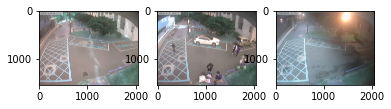

In [99]:
if __name__=='__main__':
    
    # video entropy Edge histogram
    video_list = [
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-09_09:31:53.mp4',
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-12_15:00:36.mp4',
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/Pole1_2020-08-10_23-59-43.mp4'
    ]
    
    for i in range(3):
        vs = cv2.VideoCapture(video_list[i])
        start_time = time.time()
        ret, frame = vs.read()
        frame = np.array(frame)
        edgeHistogramComputer = EdgeHistogramComputer(6,6)
        hist = edgeHistogramComputer.compute(frame)
        hist = hist.flatten()
        print("Entropy:", entropy(hist), "FPS:", 1/(time.time()-start_time))
        plt.subplot(1,3,i+1)
        plt.imshow(frame)

## CNN feature

In [14]:
import numpy as nd
input_path = './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-09_09:31:53.mp4'

cap = cv2.VideoCapture(input_path)

ret, frame = cap.read()
# frame = tf.image.rgb_to_grayscale(frame)
frame = tf.image.resize(frame, [512,512], method=ResizeMethod.BILINEAR,)
frame = tf.expand_dims(frame, axis=0)


initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
kernel = initializer(shape=(2, 2, 3, 3))

conv_feature = tf.nn.conv2d(frame, kernel, strides=[1, 1, 1, 1], padding='VALID')
print(conv_feature.shape)


(1, 511, 511, 3)


In [28]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
kernel = initializer(shape=(2, 2, 3, 3))

In [30]:
if __name__=='__main__':
    
    # video entropy Edge histogram
    video_list = [
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-09_09:31:53.mp4',
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-12_15:00:36.mp4',
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/result_Pole1_2020-08-10_23-59-43.mp4'
    ]
    
    for i in range(3):
        vs = cv2.VideoCapture(video_list[i])
        start_time = time.time()
        ret, frame = vs.read()
        frame = tf.image.resize(frame, [512,512], method=ResizeMethod.BILINEAR)
        frame = tf.expand_dims(frame, axis=0)
        
        conv_feature = tf.nn.conv2d(frame, kernel, strides=[1, 1, 1, 1], padding='VALID')
        entropy_value=0
        for channel in range(3):
            signal = tf.keras.backend.flatten(conv_feature[:,:,:,channel]).numpy().round()
            entropy_value += entropy(signal)
            
        print("Entropy:", entropy_value, "FPS:", 1/(time.time()-start_time))
#         plt.subplot(1,3,i+1)
#         plt.imshow(frame)

Entropy: 26.60734765251565 FPS: 2.5586070083914274
Entropy: 27.030034528086635 FPS: 2.4613578973992127
Entropy: 27.17799691183339 FPS: 2.659515957524382


## CRNN feature

In [34]:
import tensorflow as tf

r"""Performs the 1-D Convolutional RNN Operation, according to the paper:
  Convolutional RNN: an Enhanced Model for Extracting Features from Sequential Data (https://arxiv.org/abs/1602.05875)
  Gil Keren and Bjoern Schuller. 
  Calling the below function is equivalnet to applying one CRNN layer. For a deep model with a few
  CRNN layers, the function should be invoked multiple times. 
  Given a tensor, the function extracts patches of `kernel_size` time-steps, and processed each 
  with one or more recurrent layers. The hidden state of the recurrent neural network is then 
  returned as the feature vector representing the path. 
  Args:
    tensor: The tensor to perform the operation on, shape `[batch, time-steps, features]`
            or `[batch, time-steps, features, 1]`.
    kernel_size: The number of time-steps to include in every patch/window (same as in standard 1-D convolution).
    stride: the number of time-steps between two consecutive patches/windows (same as in standard 1-D convolution).
    out_channels: The number of extracted features from each patch/window (in standard 1-D convolution 
                  known as the number of feature maps), which is the hidden dimension of the recurrent 
                  layers that processes each patch/window.
    rnn_n_layers: The number of recurrent layers to process the patches/windows. 
		  (in the original paper was always =1). 
    rnn_type: Type of recurrent layers to use: `simple`/`lstm`/`gru`
    bidirectional: Whether to use a bidirectional recurrent layers (such as BLSTM, when the rnn_type is 'lstm'). 
                   If True, The actual number of extracted features from each patch/window is `2 * out_channels`.
    w_std: Weights in the recurrent layers will be initialized randomly using a Gaussaian distribution with
           zero mean and a standard deviation of `w_std`. Biases are initialized with zero. 
    padding: `SAME` or `VALID` (same as in standard 1-D convolution).
    scope_name: For variable naming, the name prefix for variables names.  
  Returns:
    A 3-D `Tensor` with shape `[batch, time-steps, features]`, similarly to the output of a standard 1-D convolution. 
  """
def crnn(tensor, kernel_size, stride, out_channels, rnn_n_layers, rnn_type, bidirectional, w_std, padding):
#     with tf.variable_scope(scope_name, initializer=tf.truncated_normal_initializer(stddev=w_std)):
    # Expand to have 4 dimensions if needed
    if len(tensor.shape) == 3:
        tensor = tf.expand_dims(tensor, 3)

    # Extract the patches (returns [batch, time-steps, 1, patch content flattened])
    batch_size = tensor.shape[0]
    n_in_features = tensor.shape[2]
    patches = tf.image.extract_patches(images=tensor, 
                             sizes=[1, kernel_size, n_in_features, 1], 
                             strides=[1, stride, n_in_features, 1], 
                             rates=[1, 1, 1, 1], 
                             padding=padding)
    patches = patches[:, :, 0, :]
    

    # Reshape to do: 
    # 1) reshape the flattened patches back to [kernel_size, n_in_features]
    # 2) combine the batch and time-steps dimensions (which will be the new 'batch' size, for the RNN)
    # now shape will be [batch * time-steps, kernel_size, n_features]
    time_steps_after_stride = patches.shape[1]
    patches = tf.reshape(patches, [batch_size * time_steps_after_stride, kernel_size, n_in_features])
    print(patches.shape)

    # Transpose and convert to a list, to fit the tf.contrib.rnn.static_rnn requirements
    # Now will be a list of length kernel_size, each element of shape [batch * time-steps, n_features]
#     patches = tf.unstack(tf.transpose(patches, [1, 0, 2]))
    patches = tf.transpose(patches, [1, 0, 2])


    # Create the RNN Cell
    if rnn_type == 'simple':
        rnn_cell = tf.keras.layers.SimpleRNNCell
    elif rnn_type == 'lstm':
        rnn_cell = tf.keras.layers.LSTMCell
    elif rnn_type == 'gru':
        rnn_cell = tf.keras.layers.GRUCell

    rnn_cell_func = rnn_cell(out_channels)
    
    if not bidirectional:
        layer = tf.keras.layers.RNN(rnn_cell_func, return_sequences=True, go_backwards=False)
        outputs = layer(patches)
    else:
        forward_layer = tf.keras.layers.RNN(rnn_cell_func, return_sequences=True, return_state=False,go_backwards=False)
        backward_layer = tf.keras.layers.RNN(rnn_cell_func, return_sequences=True, return_state=False,go_backwards=True)
        layer = tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer)
        outputs = layer(patches)
    

#     # Multilayer RNN? (does not appear in the original paper)
#     if rnn_n_layers > 1:
#         if not bidirectional:
#             rnn_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell] * rnn_n_layers)
#         else:
#             rnn_cell_f = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell_f] * rnn_n_layers)
#             rnn_cell_b = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell_b] * rnn_n_layers)
    

    
        
    # Use only the output of the last time-step (shape will be [batch * time-steps, out_channels]).
    # In the case of a bidirectional RNN, we want to take the last time-step of the forward RNN, 
    # and the first time-step of the backward RNN. 
    if not bidirectional:
        outputs = outputs[-1]
    else:
        half = int(outputs[0].shape.as_list()[-1] / 2)
        outputs = tf.concat([outputs[-1][:,:half], 
                           outputs[0][:,half:]], 
                          axis=1)

    # Expand the batch * time-steps back (shape will be [batch_size, time_steps, out_channels]
    if bidirectional:
        out_channels = 2 * out_channels
    outputs = tf.reshape(outputs, [batch_size, time_steps_after_stride, out_channels])
    
    return outputs

In [35]:
import numpy as nd
input_path = './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-09_09:31:53.mp4'

cap = cv2.VideoCapture(input_path)
frame_count=0

while frame_count<6:
    ret, frame = cap.read()
    
#     frame = tf.image.rgb_to_grayscale(frame)
    frame = tf.image.resize(frame, [128,128], method=ResizeMethod.BILINEAR)
        
    if frame_count ==0:
        frame_sequence_tensor = frame
    frame_sequence_tensor = np.vstack((frame_sequence_tensor, frame))
    frame_count += 1
    

# frame_sequence_tensor = tf.transpose(frame_sequence_tensor, [1, 0, 2])
print(frame_sequence_tensor.shape)
output_feature = crnn(frame_sequence_tensor, kernel_size=6, stride=1, out_channels=3, rnn_n_layers=1, rnn_type='lstm', bidirectional=0, w_std=0, padding='SAME')


(896, 128, 3)
tf.Tensor(
[[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-8.3933617e-33  2.1932015e-11 -0.0000000e+00]
  ...
  [-0.0000000e+00 -1.0034688e-11 -0.0000000e+00]
  [-1.3084787e-37 -1.0023126e-11 -0.0000000e+00]
  [-0.0000000e+00 -1.0015019e-11 -0.0000000e+00]]

 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [-8.3933617e-33  2.1932015e-11 -0.0000000e+00]
  [-4.2906727e-33  3.8421356e-11 -0.0000000e+00]
  ...
  [-1.3084787e-37  1.7140587e-13 -0.0000000e+00]
  [-0.0000000e+00  1.7183574e-13 -0.0000000e+00]
  [-0.0000000e+00  1.7189769e-13 -0.0000000e+00]]

 [[-8.3933617e-33  2.1932015e-11 -0.0000000e+00]
  [-4.2906727e-33  3.8421356e-11 -0.0000000e+00]
  [-4.2906727e-33  5.4125194e-11 -0.0000000e+00]
  ...
  [-0.0000000e+00  1.7183574e-13 -0.0000000e+00]
  [-0.0000000e+00  1.7189769e-13 -0.0000000e+00]
  [-0.0000000e+00  1.7202112e-13 -0.0000000e+00]]

 [[-4.2906727e-33  1.7534120e-11 -0.0000000e+00]
  [-4.2906727e-33  3

array([[[ 82.25,  82.25,  82.25],
        [ 83.  ,  83.  ,  83.  ],
        [ 83.  ,  83.  ,  83.  ],
        ...,
        [ 62.75,  61.75,  55.75],
        [ 48.25,  47.25,  41.25],
        [ 36.5 ,  35.5 ,  29.5 ]],

       [[ 80.5 ,  80.5 ,  80.5 ],
        [170.  , 170.  , 170.  ],
        [170.  , 170.  , 170.  ],
        ...,
        [ 67.  ,  66.  ,  60.  ],
        [ 56.25,  55.25,  49.25],
        [ 45.25,  44.25,  38.25]],

       [[ 81.25,  81.25,  81.25],
        [170.5 , 170.5 , 170.5 ],
        [170.  , 170.  , 170.  ],
        ...,
        [ 70.  ,  69.  ,  63.  ],
        [ 67.  ,  66.  ,  60.  ],
        [ 52.75,  51.75,  45.75]],

       ...,

       [[125.5 , 106.  , 101.5 ],
        [124.  , 105.25,  98.75],
        [125.  , 105.  , 101.5 ],
        ...,
        [ 88.5 , 105.  ,  93.5 ],
        [ 93.5 , 112.5 ,  98.5 ],
        [ 94.75, 113.75,  99.75]],

       [[125.  , 105.5 , 101.  ],
        [123.  , 104.5 ,  97.5 ],
        [125.  , 104.  , 103.  ],
        .

In [24]:
output_feature.shape

TensorShape([896, 128, 3])

In [32]:
output_feature = tf.transpose(output_feature, [1, 0, 2])
print(output_feature.shape)
entropy_value=0
for channel in range(3):
    signal = tf.keras.backend.flatten(output_feature[:,:,channel]).numpy().round()
    entropy_value += entropy(signal)
print(entropy_value)

(896, 128, 3)
0.4920130393204205


In [ ]:
if __name__=='__main__':
    
    # video entropy Edge histogram
    video_list = [
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-09_09:31:53.mp4',
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/LiteOn_P1_2019-11-12_15:00:36.mp4',
        './storage_server_volume/raw_videos/raw_11_9/ipcam1/Pole1_2020-08-10_23-59-43.mp4'
    ]
    for i in range(3):
        vs = cv2.VideoCapture(video_list[i])
        start_time = time.time()
        frame_count=0
        while frame_count<6:
            ret, frame = cap.read()
        #     frame = tf.image.rgb_to_grayscale(frame)
            frame = tf.image.resize(frame, [128,128], method=ResizeMethod.BILINEAR)

            if frame_count ==0:
                frame_sequence_tensor = frame
            frame_sequence_tensor = np.vstack((frame_sequence_tensor, frame))
            frame_count += 1

        print(frame_sequence_tensor.shape)
        output_feature = crnn(frame_sequence_tensor, kernel_size=6, stride=1, out_channels=3, rnn_n_layers=1, rnn_type='lstm', bidirectional=0, w_std=1, padding='SAME')
        output_feature = tf.transpose(output_feature, [1, 0, 2])

        entropy_value=0
        for channel in range(3):
            signal = tf.keras.backend.flatten(output_feature[:,:,channel]).numpy().round()
            entropy_value += entropy(signal)

    print("Entropy:", entropy_value, "FPS:", 1/(time.time()-start_time))